--- INICIANDO COMPARATIVA ---
Tiempo Cuántico (Simulado): 2.2306 segundos
Tiempo Clásico (Exacto):    0.0001 segundos
¿Los resultados coinciden? Sí


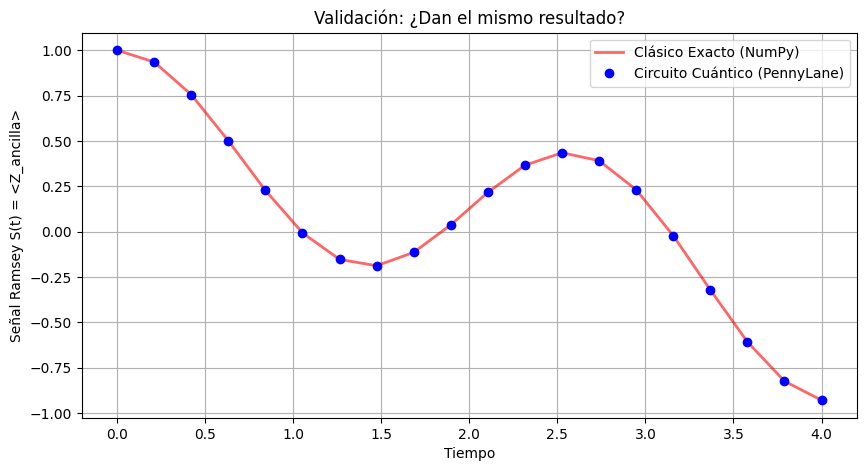

In [1]:
import time
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

def run_quantum_simulation(t_values, u_imp_val, steps_trotter=30):
    # Wires
    ANCILLA, SYS_UP, SYS_DOWN, IMPURITY = 0, 1, 2, 3
    wires_list = [ANCILLA, SYS_UP, SYS_DOWN, IMPURITY]
    
    # Parámetros físicos
    EPS_UP, EPS_DOWN, EPS_IMP = 0.5, 0.5, 0.2
    U_FF = 2.0
    THETA_BCS = 1.57 # Pi/2

    # IMPORTANTE: shots=None para resultados analíticos exactos (sin ruido)
    dev = qml.device("default.qubit", wires=wires_list, shots=None)

    def get_hamiltonian_coeffs_ops(u_val):
        coeffs = []
        ops = []
        # H_kin (Términos Z)
        for w, eps in zip([SYS_UP, SYS_DOWN, IMPURITY], [EPS_UP, EPS_DOWN, EPS_IMP]):
            coeffs.append(-0.5 * eps)
            ops.append(qml.PauliZ(w))
        # H_int (Términos ZZ)
        interactions = [(SYS_UP, SYS_DOWN, U_FF), (IMPURITY, SYS_UP, u_val), (IMPURITY, SYS_DOWN, u_val)]
        for w1, w2, U in interactions:
            c = -0.25 * U
            coeffs.append(c); ops.append(qml.PauliZ(w1))
            coeffs.append(c); ops.append(qml.PauliZ(w2))
            coeffs.append(0.25 * U); ops.append(qml.PauliZ(w1) @ qml.PauliZ(w2))
        return coeffs, ops

    @qml.qnode(dev)
    def circuit(time_pt):
        # 1. Preparación estado (Ansatz BCS)
        qml.RY(THETA_BCS, wires=SYS_UP)
        qml.CNOT(wires=[SYS_UP, SYS_DOWN])
        
        # 2. Ramsey Inicio
        qml.Hadamard(wires=ANCILLA)
        
        # 3. Evolución Controlada (Trotter)
        if time_pt > 0:
            dt = time_pt / steps_trotter
            c, o = get_hamiltonian_coeffs_ops(u_imp_val)
            for _ in range(steps_trotter):
                for coeff, op in zip(c, o):
                    if len(op.wires) == 1:
                        qml.ctrl(qml.RZ, control=ANCILLA)(2 * coeff * dt, wires=op.wires)
                    else:
                        qml.ctrl(qml.MultiRZ, control=ANCILLA)(2 * coeff * dt, wires=op.wires)
        
        # 4. Ramsey Fin
        qml.Hadamard(wires=ANCILLA)
        return qml.probs(wires=ANCILLA)

    # Bucle temporal
    signal = []
    for t in t_values:
        probs = circuit(t)
        # S(t) = P(0) - P(1) es equivalente a <Z>
        signal.append(probs[0] - probs[1]) 
    
    return np.array(signal)


# 2. CÓDIGO CLÁSICO "REAL" (Ajustado a Pauli Z)
def run_classical_simulation(t_values, u_imp_val):
    # Parámetros
    EPS_UP, EPS_DOWN, EPS_IMP = 0.5, 0.5, 0.2
    U_FF = 2.0
    THETA_BCS = 1.57 # Pi/2
    
    dim = 8
    H_diag = np.zeros(dim)
    
    # --- CONSTRUCCIÓN DEL HAMILTONIANO EXACTO (Pauli Z) ---
    # Para que coincida con PennyLane, calculamos la energía sumando
    # los mismos términos que usa el circuito cuántico.
    # Base binaria: |n_imp, n_down, n_up>
    
    for i in range(dim):
        # Extraemos bits (0 o 1)
        bit_up   = (i >> 0) & 1
        bit_down = (i >> 1) & 1
        bit_imp  = (i >> 2) & 1
        
        # Convertimos a autovalores Z (+1 si bit es 0, -1 si bit es 1)
        z_up   = 1 if bit_up == 0 else -1
        z_down = 1 if bit_down == 0 else -1
        z_imp  = 1 if bit_imp == 0 else -1
        
        # Sumamos términos EXACTAMENTE como en get_hamiltonian_coeffs_ops
        E = 0
        
        # 1. Términos Cinéticos (-0.5 * eps * Z)
        E += -0.5 * EPS_UP * z_up
        E += -0.5 * EPS_DOWN * z_down
        E += -0.5 * EPS_IMP * z_imp
        
        # 2. Interacciones
        # Definimos lista local para iterar igual que en cuántico
        ints = [(z_up, z_down, U_FF), (z_imp, z_up, u_imp_val), (z_imp, z_down, u_imp_val)]
        for z1, z2, U in ints:
            # c = -0.25 * U
            E += (-0.25 * U) * z1
            E += (-0.25 * U) * z2
            E += (0.25 * U) * (z1 * z2)
            
        H_diag[i] = E

    # 2. Vector de Estado Inicial
    # PennyLane: RY(theta)|0> -> cos(t/2)|0> + sin(t/2)|1>
    # Estado: cos|000> + sin|011> (orden imp, down, up)
    psi0 = np.zeros(dim)
    u = np.cos(THETA_BCS / 2)
    v = np.sin(THETA_BCS / 2)
    
    # |000> -> indice 0
    # |011> -> indice 3 (binario 011)
    psi0[0] = u
    psi0[3] = v 
    
    # 3. Evolución
    # Como H es diagonal, la exponenciación es trivial
    # S(t) = Re[ <psi0 | e^-iHt | psi0> ]
    #      = Sum |c_k|^2 * cos(E_k * t)
    
    signal = np.zeros_like(t_values)
    
    # Pesos de cada estado base (|c_k|^2)
    weights = np.abs(psi0)**2
    
    for k in range(dim):
        if weights[k] > 0: # Solo sumamos componentes pobladas
            signal += weights[k] * np.cos(H_diag[k] * t_values)
        
    return signal


# 3. BENCHMARK

print("--- INICIANDO COMPARATIVA ---")
# Usamos un poco más de tiempo para ver oscilaciones completas
t_points = np.linspace(0, 4.0, 20) 
u_test = 2.5

# A. Medir Cuántico
start_q = time.time()
# Más trotter steps = más precisión (pero más lento)
res_q = run_quantum_simulation(t_points, u_test, steps_trotter=30)
end_q = time.time()
time_q = end_q - start_q

print(f"Tiempo Cuántico (Simulado): {time_q:.4f} segundos")

# B. Medir Clásico
start_c = time.time()
res_c = run_classical_simulation(t_points, u_test)
end_c = time.time()
time_c = end_c - start_c

# Validación con tolerancia relajada (por error de Trotter)
dan_el_mismo_resultado = np.allclose(res_q, res_c, atol=0.05) 

print(f"Tiempo Clásico (Exacto):    {time_c:.4f} segundos")
print(f"¿Los resultados coinciden? {'Sí' if dan_el_mismo_resultado else 'No (diferencia por Trotter)'}")


# 4. VALIDACIÓN VISUAL

plt.figure(figsize=(10, 5))
# Graficamos ambos
plt.plot(t_points, res_c, '-', label='Clásico Exacto (NumPy)', color='red', linewidth=2, alpha=0.6)
plt.plot(t_points, res_q, 'o', label='Circuito Cuántico (PennyLane)', color='blue', markersize=6)

plt.title("Validación: ¿Dan el mismo resultado?")
plt.xlabel("Tiempo")
plt.ylabel("Señal Ramsey S(t) = <Z_ancilla>")
plt.legend()
plt.grid(True)
plt.show()